# HousePricePrediction

In [163]:
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.set_option('max_rows', 10, 'max_columns', 30)
%matplotlib inline

### Dataset
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [164]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
test_id = df_test['id']

In [165]:
print("train set 데이터량", df.shape)
print("test set 데이터량", df_test.shape)

train set 데이터량 (15035, 21)
test set 데이터량 (6468, 20)


### EDA & Preprocessing

#### Null Data 확인
- 다음 정보를 통해 train data와 test data에 Null 값이 없는 것을 확인 할 수 있습니다. 하지만, Null data는 없을 지라도 다른 결측치가 있을 수 있다는 것은 염두해 두어야 합니다. 
- 추후에 feature 별로 자세히 살펴볼 때, Null 이 아닌 다른 결측치가 있을지 확인해 보아야 합니다.

In [166]:
print("Train set 데이터 정보: \n", df.info())
print('------------\n')
print("Test set 데이터 정보: \n", df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
id               15035 non-null int64
date             15035 non-null object
price            15035 non-null float64
bedrooms         15035 non-null int64
bathrooms        15035 non-null float64
sqft_living      15035 non-null int64
sqft_lot         15035 non-null int64
floors           15035 non-null float64
waterfront       15035 non-null int64
view             15035 non-null int64
condition        15035 non-null int64
grade            15035 non-null int64
sqft_above       15035 non-null int64
sqft_basement    15035 non-null int64
yr_built         15035 non-null int64
yr_renovated     15035 non-null int64
zipcode          15035 non-null int64
lat              15035 non-null float64
long             15035 non-null float64
sqft_living15    15035 non-null int64
sqft_lot15       15035 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 2.4+ MB
Train set 데이터 정보: 


#### `price` : target 분포 확인 및 전처리
- target value 의 분포가 정규분포와는 거리가 멉니다.
- skewness 가 0보다 큼을 분포 모양이 왼쪽으로 치우쳐져 있는 형태를 통해서도 확인할 수 있으며, 수치들을 통해서도 확인할 수 있습니다.
- kurtosis 역시 매우 뾰족한 분포 모양을 통해서도 알 수 있고, 그 수치가 나타남을 확인 할 수 있습니다.

skewness:  4.290252396939529
kurtosis: 40.15491919350329


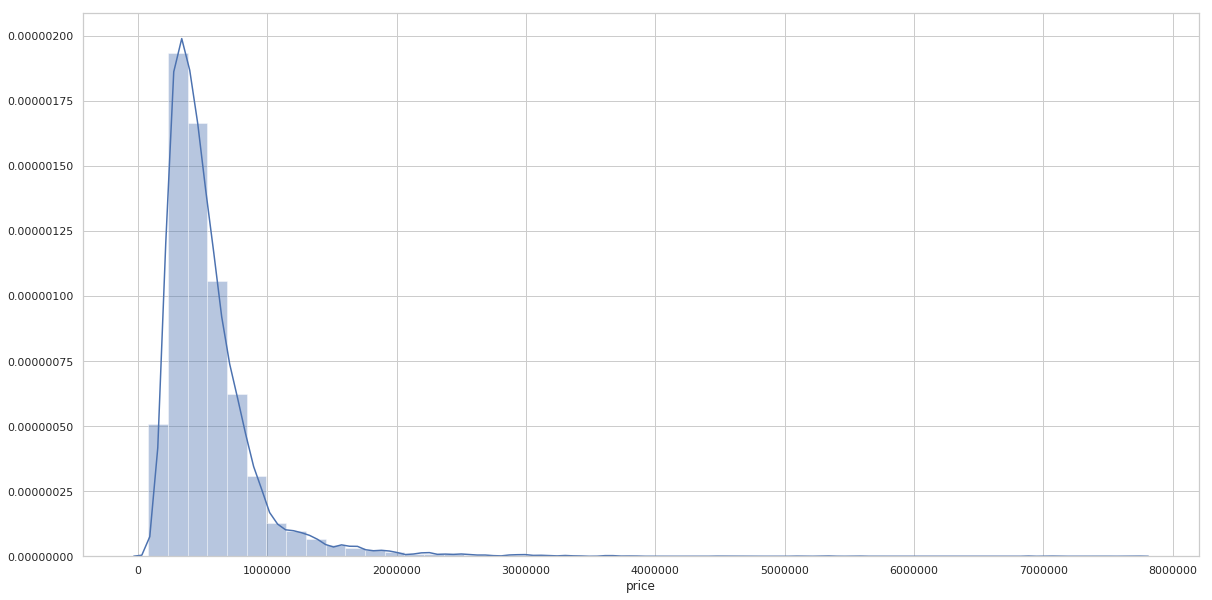

In [167]:
print("skewness: ", df['price'].skew())
print("kurtosis:", df['price'].kurt())
plt.figure(figsize=(20, 10))
sns.distplot(df['price'])

- `price` 분포를 좀더 정규화 해주기 위해, logarithm 을 취해줍니다. 꼭 잊지말고, 최종 예측치에서는 exponential 을 취해주어야 합니다.

In [168]:
original_price = df['price'] # save original price 
df['price'] = np.log1p(df['price'])

#### `date` : 형식 확인 및 전처리
- `Date` Column 이 모두 **날짜(숫자 8자리) + T000000** pattern 으로 되어있는지 확인해봅니다.
    - 확인결과, 모두 숫자, T000000 형태가 붙어있는 것을 확인 할 수 있습니다. (True)

In [169]:
def regex(data):
    pattern = re.compile('^[0-9]{8}T000000$')
    match = pattern.match(data)
    if match:
        return True
    else:
        return False
    
date_pattern_check_series = df['date'].apply(lambda data: regex(data))
print(all(date_pattern_check_series))
del date_pattern_check_series

True


- 모두 같은 형태임을 확인했으므로, 날짜형식만자리까지만 자신있게 제거해줍니다.

In [170]:
df['date'] = df['date'].apply(lambda data: data[:8])
df_test['date'] = df_test['date'].apply(lambda data: data[:8])

- `date`를 활용해 매달 주택의 거래량과 그 평균 price 를 확인해 보겠습니다.
    - 거래량이 많은 달에는 평균 가격이 비교적 높은 것을 확인 할 수 있습니다.
    - 2015년 05월에는 거래량이 다른 다른달에 비해 많지 않은데도 불구하고, 평균 가격이 높은 특이점도 확인 할 수 있습니다.
    - 시계열 적인 데이터의 수가 많지 않고, 부족하기 때문에, 월별 주기성을 확정 할 수 는 없지만 `date` column 을 drop 하고, yearmonth data 를 dummy 변수로 활용하겠습니다.

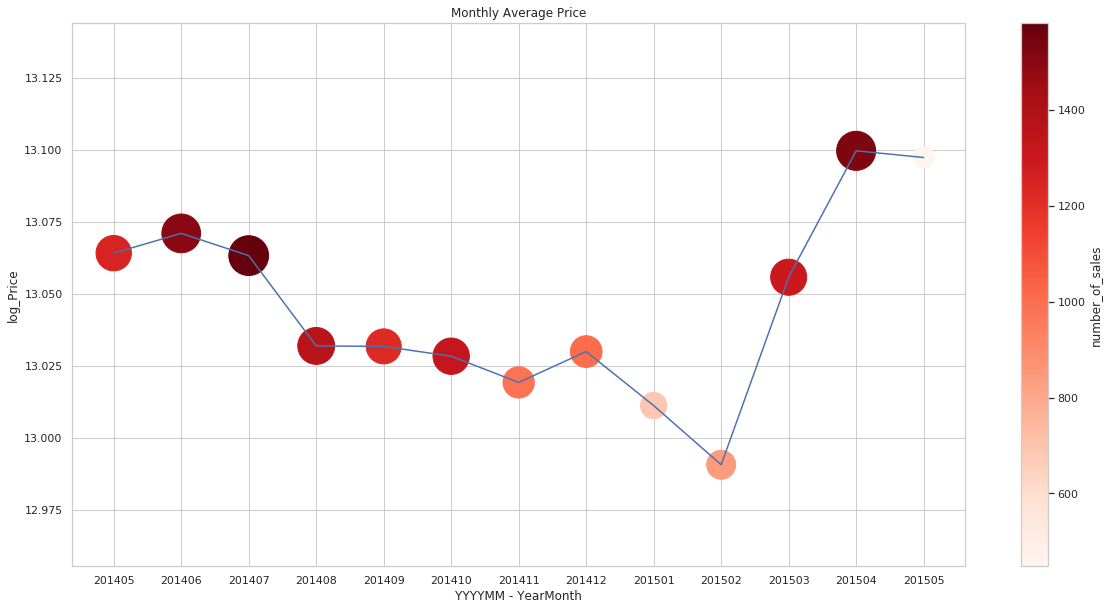

In [171]:
df['yrmth'] = df['date'].apply(lambda data: data[:6])
df_test['yrmth'] = df_test['date'].apply(lambda data: data[:6])

yrmth_df = df.groupby('yrmth')['price'].agg({'mean_price': 'mean', 
                                             'number_of_sales': 'count'})
vmin = np.min(yrmth_df['number_of_sales'])
vmax = np.max(yrmth_df['number_of_sales'])

plt.figure(figsize=(20, 10))

plt.scatter(np.arange(yrmth_df.shape[0]), yrmth_df['mean_price'], c=yrmth_df['number_of_sales'], \
            s=yrmth_df['number_of_sales'], vmin=vmin, vmax=vmax, cmap=plt.cm.Reds)
plt.colorbar(label='number_of_sales')

plt.plot(np.arange(yrmth_df.shape[0]), yrmth_df['mean_price'])

plt.title('Monthly Average Price')
plt.xticks(np.arange(yrmth_df.shape[0]), yrmth_df.index.values)
plt.xlabel('YYYYMM - YearMonth')
plt.ylabel('log_Price')
plt.show()

In [172]:
df['date'] = df['date'].apply(lambda data: int(data))
df_test['date'] = df_test['date'].apply(lambda data: int(data))

In [173]:
df = pd.get_dummies(df, columns=['yrmth'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['yrmth'], drop_first=True)

# df = df.drop('date', axis=1)
# df_test = df_test.drop('date', axis=1)

### `sqft_living`, `sqft_living15`,  `sqft_basement`, `sqft_above`, `sqft_lot`, `sqft_lot15`
- `sqft_living`, `sqft_basement`, `sqft_above` 간의 관계를 확인해 봅니다.
    - 확인결과, `sqft_living`은 `sqft_basement` 와 `sqft_above`를 더한 값임을 확인 할 수 있습니다.
    - 독립변수간에 상관성이 매우 높을 것이 예상되므로, `sqft_basement`는 지하실이 있는지 유무로 categorical variable 로 바꿔주고, drop하겠습니다.

In [174]:
all(df['sqft_living'] == (df['sqft_basement'] + df['sqft_above']))

True

In [175]:
pre_sqft_df = df
pre_sqft_df['basement_dummy'] = pre_sqft_df['sqft_basement'].apply(lambda data: 1 if data > 0 else 0)
df_test['basement_dummy'] = df_test['sqft_basement'].apply(lambda data: 1 if data > 0 else 0)

pre_sqft_df = pre_sqft_df.drop('sqft_basement', axis=1)
df_test = df_test.drop('sqft_basement', axis=1)
pre_sqft_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,...,sqft_living15,sqft_lot15,yrmth_201406,yrmth_201407,yrmth_201408,yrmth_201409,yrmth_201410,yrmth_201411,yrmth_201412,yrmth_201501,yrmth_201502,yrmth_201503,yrmth_201504,yrmth_201505,basement_dummy
0,0,20141013,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,1955,0,...,1340,5650,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,20150225,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,1933,0,...,2720,8062,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,20150218,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,1987,0,...,1800,7503,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,20140627,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,1995,0,...,2238,6819,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,20150115,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,1963,0,...,1650,9711,0,0,0,0,0,0,0,1,0,0,0,0,0


- `sqft_living`, `sqft_living15`, `sqft_above`, `sqft_lot`, `sqft_lot15` 의 skewness를 확인합니다.
    - skewness 가 비교적 큰 것 (저의 경우 그 기준을 1로 하였습니다.) 1보다 큰 skewness 를 logarithm 을 취해줍니다.

In [176]:
print("sqft_living skewness: ", pre_sqft_df['sqft_living'].skew())
print("sqft_living15 skewness: ", pre_sqft_df['sqft_living15'].skew())
print("sqft_above skewness: ", pre_sqft_df['sqft_above'].skew())
print("sqft_lot skewness: ", pre_sqft_df['sqft_lot'].skew())
print("sqft_lot15 skewness: ", pre_sqft_df['sqft_lot15'].skew())

sqft_living skewness:  1.4924715984991939
sqft_living15 skewness:  1.1259322266124485
sqft_above skewness:  1.429070221714329
sqft_lot skewness:  13.35050013446013
sqft_lot15 skewness:  10.028411904577348


In [177]:
skew_list = ['sqft_living', 'sqft_living15', 'sqft_above', 'sqft_lot', 'sqft_lot15']
for skew in skew_list:
    pre_sqft_df[skew] = pre_sqft_df[skew].apply(lambda data: np.log1p(data))
    df_test[skew] = df_test[skew].apply(lambda data: np.log1p(data))

In [178]:
print("sqft_living skewness: ", pre_sqft_df['sqft_living'].skew())
print("sqft_living15 skewness: ", pre_sqft_df['sqft_living15'].skew())
print("sqft_above skewness: ", pre_sqft_df['sqft_above'].skew())
print("sqft_lot skewness: ", pre_sqft_df['sqft_lot'].skew())
print("sqft_lot15 skewness: ", pre_sqft_df['sqft_lot15'].skew())

sqft_living skewness:  -0.03745962412709876
sqft_living15 skewness:  0.21076642835473083
sqft_above skewness:  0.23741190055202538
sqft_lot skewness:  0.9899185058491824
sqft_lot15 skewness:  0.9902731410872413


In [179]:
y_label = pre_sqft_df['price']
X_data = pre_sqft_df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=20190319)

In [87]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor()

parameters = {
    'max_depth': [3, 7],
    'n_estimators': [500, 1000],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'colsample_bytree': [0.5, 0.7],
    'subsample': [0.5, 0.7, 0.8],
    'min_child_weight': [1, 5]
    
}
xgb_grid = GridSearchCV(xgb, parameters, cv=5, n_jobs=5, verbose=1)
xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   56.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 16.1min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 31.2min
[Parallel(n_jobs=5)]: Done 960 out of 960 | elapsed: 39.9min finished


0.9082011762931045
{'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.7}


In [108]:
xgb = XGBRegressor(colsample_bytree=0.5, learning_rate=0.03, max_depth=7, min_child_weight=1, \
                   n_estimators=1000, subsample=0.7)
xgb.fit(X_data, y_label)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [153]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 32 columns):
id                15035 non-null int64
date              15035 non-null object
bedrooms          15035 non-null int64
bathrooms         15035 non-null float64
sqft_living       15035 non-null float64
sqft_lot          15035 non-null float64
floors            15035 non-null float64
waterfront        15035 non-null int64
view              15035 non-null int64
condition         15035 non-null int64
grade             15035 non-null int64
sqft_above        15035 non-null float64
yr_built          15035 non-null int64
yr_renovated      15035 non-null int64
zipcode           15035 non-null int64
lat               15035 non-null float64
long              15035 non-null float64
sqft_living15     15035 non-null float64
sqft_lot15        15035 non-null float64
yrmth_201406      15035 non-null uint8
yrmth_201407      15035 non-null uint8
yrmth_201408      15035 non-null uint8
yrmth_201409  

In [180]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.07, colsample_bytree=0.7, subsample=0.8)
xgb_reg.fit(X_data, y_label)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [181]:
#
xgb_predict = xgb_reg.predict(df_test)
xgb_predict = np.expm1(xgb_predict)

submission = pd.DataFrame({'id': test_id,
                          'price': xgb_predict})
submission.head()

,id,price
0,15035,5.547912e+05
1,15036,4.536362e+05
2,15037,1.439972e+06
3,15038,3.211153e+05
4,15039,3.203030e+05


In [94]:
# y_pred = xgb.predict(X_test)

# rmsle = np.sqrt(mean_squared_error(y_test, y_pred))

# y_pred = np.expm1(y_pred)
# y_test = np.expm1(y_test)

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print("rmsle", rmsle)
# print("rmse", rmse)

rmsle 0.15827099782440657
rmse 141689.620449872


In [112]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()

parameters = {
    'max_depth': [3, 7],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'colsample_bytree': [0.5, 0.7],
    'subsample': [0.5, 0.7, 0.8],
    'min_child_weight': [0.001, 0.1, 1],
    'num_leaves': [20, 30, 40]
    
}
lgbm_grid = GridSearchCV(lgbm, parameters, cv=5, n_jobs=5, verbose=10)
lgbm_grid.fit(X_train, y_train)

print(lgbm_grid.best_score_)
print(lgbm_grid.best_params_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:   12.5s
[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:   15.3s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   15.8s
[Parallel(n_jobs=5)]: Done 171 tasks      | elapsed:   16.5s
[Parallel(

0.9066361305197663
{'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 0.001, 'n_estimators': 1000, 'num_leaves': 40, 'subsample': 0.5}


In [121]:
lgbm = LGBMRegressor(colsample_bytree=0.5, learning_rate=0.03, max_depth=7, min_child_weight=0.001, n_estimators=1000, num_leaves=40, subsample=0.5)

lgbm.fit(X_data, y_label)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
       importance_type='split', learning_rate=0.03, max_depth=7,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=40, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.5, subsample_for_bin=200000, subsample_freq=0)

In [122]:
#
lgbm_predict = lgbm.predict(df_test)
lgbm_predict = np.expm1(lgbm_predict)

submission = pd.DataFrame({'id': test_id,
                          'price': lgbm_predict})
submission.head()

,id,price
0,15035,5.302817e+05
1,15036,4.753959e+05
2,15037,1.483366e+06
3,15038,3.089319e+05
4,15039,3.261365e+05


In [109]:
#
xgb_predict = xgb.predict(df_test)
xgb_predict = np.expm1(xgb_predict)

submission = pd.DataFrame({'id': test_id,
                          'price': xgb_predict})
submission.head()

,id,price
0,15035,5.279218e+05
1,15036,4.556789e+05
2,15037,1.470348e+06
3,15038,3.204014e+05
4,15039,3.256097e+05


In [182]:
submission.to_csv('./submission.csv', index=False)

In [31]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor


# xgb = XGBRegressor()
# lgbm = LGBMRegressor()
# parameters_xgb = {
#     'max_depth': [3, 5, 7, 9],
#     'n_estimators': [500, 1000, 1500, 2000],
#     'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.4],
#     'colsample_bytree': [0.1, 0.3, 0.5, 0.7],
#     'subsample': [0.5, 0.7, 0.8],
#     'min_child_weight': [1, 10, 100]
# }
# parameters_lgbm = {
#     'max_depth': [-1, 3, 5, 7, 9],
#     'n_estimators': [500, 1000, 1500, 2000],
#     'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.4],
#     'colsample_bytree': [0.1, 0.3, 0.5, 0.7],
#     'subsample': [0.5, 0.7, 0.8],
#     'num_leaves': [10, 20, 30, 40],
#     'min_child_weight': [1, 10, 100]
# }

# xgb_grid = GridSearchCV(xgb, parameters_xgb, cv=5, n_jobs=5)
# lgbm_grid = GridSearchCV(lgbm, parameters_lgbm, cv=5, n_jobs=5)

# xgb_grid.fit(X_train, y_train)
# lgbm_grid.fit(X_train, y_train)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)
# print(lgbm_grid.best_score_)
# print(lgbm_grid.best_params_)


KeyboardInterrupt: 

In [ ]:
# def grid_search(model, parameters, cv=5, n_jobs=5, train, test):
#     model_grid = GridSearchCV(model, parameters, cv, n_jobs)
#     model_grid.fit(train, test)
#     print(model.__class__.__name__, model_grid.best_score_)
#     print(model.__class__.__name__, model_grid.best_params_)